# Area Var

Notebook to explore population distrubtions across sub-national units by gridded population dataset

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split, add = None):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
        add = additional custom stats function must be a dict {'mymean':mymean} (see rasterstats documentation)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, add_stats = add, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        if add == None:
            zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
            polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
        
        else:
            key = list(add.keys())[0]
            zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
            zgdf = zgdf.rename(columns={key: data+'_'+key})
            polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type, data+'_'+key]], on = col, how = 'inner')
    
    return polys_out

In [3]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

In [4]:
def make_data(polys_fn, rst_fns, GID_col, stats_type, split_str, add_dic):
    
    """ Finds area of polygons and then runs zonal statistics on them across gridded population rasters
    Args:
        polys_fn = path and file name of polygons (was gdam, now GPWv4 grid polys)
        rst_fns = glob list of raster names for zonal stats
        GID_col = column of gdam level 
        stats_type = see zone_loop
        split_str = see zone_loop
        add_dic = see zone_loop
    """
    
    # open polys
    polys = gpd.read_file(polys_fn)
    
#     # calculate area
#     polys['area'] =  polys.to_crs('EPSG:3857').area
    
    # zonal stats
    polys_zone = polys[['geometry', GID_col]]
    polys_final = zone_loop(polys_in = polys_zone, rst_list = rst_fns, stats_type = stats_type, col = GID_col, 
                         split = split_str, add = add_dic)
    
    # merge
    df_out = polys_final.merge(polys[[GID_col, 'AREAKM']], on = GID_col, how = 'inner')
    
    return df_out


In [95]:
def make_plot(data, x_col, y_col, custom_xlim, custom_ylim, fn_out = None):
    
    """Makes a 1 by five plot -- need to update titles and what not
    Args:
        data = df_out from make_data
        x_col = x_column you want to plot
        y_col = y_column you want to plat by gridded product
        custom_xlim = (min, max)
        custom_ylim = (min, max)
        fn_out = if not None, path and fn to save it out
    """
    
    # for log np.log10(data['ESRI16_'+y_col].astype('float32'))
    
    # set colors
    ESRI16_c = 'blue'
    GHS15_c = 'indigo'
    GWPv4_c = 'deeppink'
    LS15_c = 'deepskyblue'
    WP16_c = 'forestgreen'
    
    # Plot
    fig, axs = plt.subplots(5, 1, figsize = (5, 18), sharex=True)
    ws = 0.25
    fig.subplots_adjust(wspace=ws)

    axs[0].scatter(np.log10(data[x_col]), data['ESRI16_'+y_col].astype('float32'), color = ESRI16_c, alpha = 0.3, s = 30, marker = '.')
    axs[1].scatter(np.log10(data[x_col]), data['GHS15_'+y_col].astype('float32'), color = GHS15_c, alpha = 0.3,s = 30, marker = '.')
    axs[2].scatter(np.log10(data[x_col]), data['GPWv4_'+y_col].astype('float32'), color = GWPv4_c,  alpha = 0.3, s = 30, marker = '.')
    axs[3].scatter(np.log10(data[x_col]), data['LS15_'+y_col].astype('float32'), color = LS15_c, alpha = 0.3, s = 30, marker = '.')
    axs[4].scatter(np.log10(data[x_col]), data['WP16_'+y_col].astype('float32'), color = WP16_c, alpha = 0.3, s = 30, marker = '.')

    # Titles
    axs[0].legend(['WPE-16'], fontsize = 13, markerscale = 2)
    axs[1].legend(['GHS-15'], fontsize = 13, markerscale = 2)
    axs[2].legend(['GWPv4-15'], fontsize = 13, markerscale = 2)
    axs[3].legend(['LS-15'], fontsize = 13, markerscale = 2)
    axs[4].legend(['WP-16'], fontsize = 13, markerscale = 2)
    axs[4].set_xlabel('Area Km$^2$ [log10]', fontsize = 20)
    axs[2].set_ylabel('Std', fontsize = 20)

    # lims
    plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim);
    
    # ticks
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    
    # save
    if fn_out != None:
        plt.savefig(fn_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

## Make plots

In [103]:
# custom stats for zonal stats
def std(X):
    return np.std(X)

# Path
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

#args
add_dic = {'std':std}
geog = ''
split_str = '_all_MMZ.tif' #NPL MMZ ECU change out
fn_out = DATA_PATH+'FIGS/MS/Fig3_MMZ.png' #NPL MMZ ECU change out
poly_fn = DATA_PATH+'interim/M3-M3-Z2.shp'#ECU-clip3.shp' #'raw/GPWv4-boundaries/gwpv4_npl_admin4.shp'' change out
rst_fns = sorted(glob(DATA_PATH+'interim/*'+split_str))
col = 'UBID' # col id from GPWv4 boundaries



In [104]:
# run it
data = make_data(polys_fn = poly_fn, rst_fns = rst_fns, GID_col = col, 
                stats_type = 'sum', split_str = split_str, add_dic = add_dic)

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


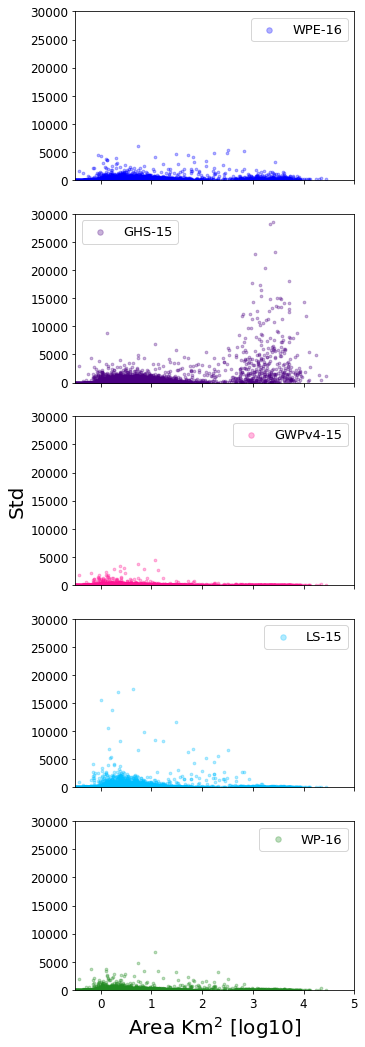

In [106]:
# def make_plot(data, x_col, custom_xlim, custom_ylim, label = None):
make_plot(data = data, x_col = 'AREAKM', 
          y_col = 'std', custom_xlim = (-.5,5), custom_ylim = (- 1, 30000),fn_out = fn_out)